In [1]:
from train import resnet_classification

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from classification_dataload import ClassificationDataset
from matplotlib import pyplot as plt
import util
import numpy
from collections import Counter

import importlib
rl = importlib.reload

In [2]:
rl(util)

<module 'util' from 'C:\\Users\\liyex\\PycharmProjects\\camera-trap-imaging\\classification\\util.py'>

In [3]:
model_ft, hist = resnet_classification(loading_model=True, model_name='resnet50_binary300', num_epochs=25)

In [4]:
model_ft.eval()
image_root = 'trainval'
target_category='species_binary'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_datasets = {x: ClassificationDataset(set_name=x, root_dir=image_root, target_category=target_category)
                  for x in ['train', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                          shuffle=False, num_workers=6)
           for x in ['train', 'validation']}

In [5]:
val_data = dataloaders['validation']
train_data = dataloaders['train']

In [6]:
classes = val_data.dataset.classes
maps = val_data.dataset.species_classes_map

In [7]:
len(val_data.dataset)

166

In [8]:
Counter(train_data.dataset.data_set_species)

Counter({'Animal': 595, 'Ghost': 345})

In [9]:
Counter(val_data.dataset.data_set_species)

Counter({'Animal': 105, 'Ghost': 61})

In [10]:
maps

{'Animal': 0, 'Ghost': 1}

In [17]:
Counter(numpy.array(val_data.dataset.cam_trap)[misclassified_index])

Counter({'CT07': 1, 'SSAMLD2': 14, 'SSAMLD2_2': 1, 'CT08': 1})

In [12]:
Counter(numpy.array(val_data.dataset.cam_trap))

Counter({'SSAMLD2': 76,
         'CT01': 50,
         'CT07': 4,
         'SSAMLD2_2': 18,
         'CT06': 7,
         'CT04': 9,
         'CT08': 2})

In [13]:
Counter(numpy.array(train_data.dataset.cam_trap))

Counter({'SSAMLD2': 385,
         'SSAMLD2_2': 129,
         'CT01': 320,
         'CT08': 13,
         'CT06': 40,
         'CT04': 45,
         'CT07': 3,
         'CT03': 5})

In [22]:
sum(numpy.array(pred_list) != numpy.array(actual_list))

17

In [23]:
from sklearn import metrics

In [27]:
metrics.confusion_matrix(y_true=actual_list, y_pred=pred_list).T

array([[105,  17],
       [  0,  44]], dtype=int64)

In [29]:
metrics.precision_score(y_true=actual_list, y_pred=pred_list, pos_label=0)

0.860655737704918

In [30]:
metrics.recall_score(y_true=actual_list, y_pred=pred_list, pos_label=0)

1.0

In [32]:
metrics.accuracy_score(y_true=actual_list, y_pred=pred_list)

0.8975903614457831

In [42]:
lr_probs = numpy.array(probablity_list)[:,0]
testy = 1 - numpy.array(actual_list)


No Skill: ROC AUC=0.500
Model: ROC AUC=0.926


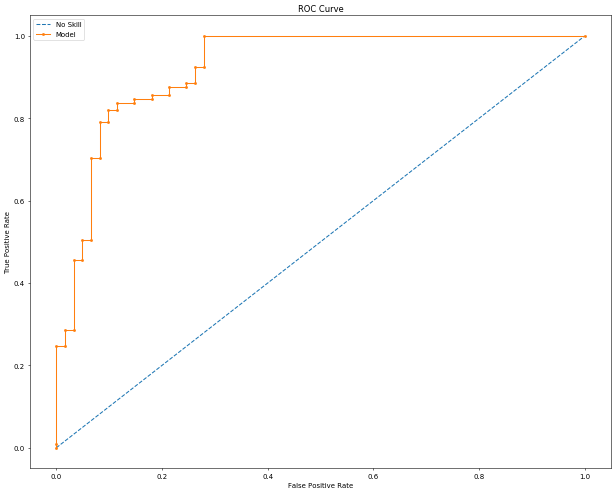

In [58]:
rl(util)
util.roc(lr_prob, testy, savefig='savefig/roc_resnet50.png')

Model: f1=0.000 auc=0.945


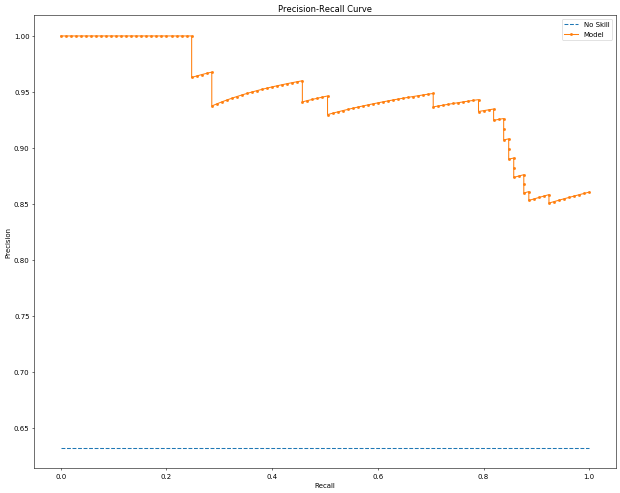

In [61]:
rl(util)
util.prc(pred_list,lr_prob, testy, savefig='savefig/prc_resnet50.png')

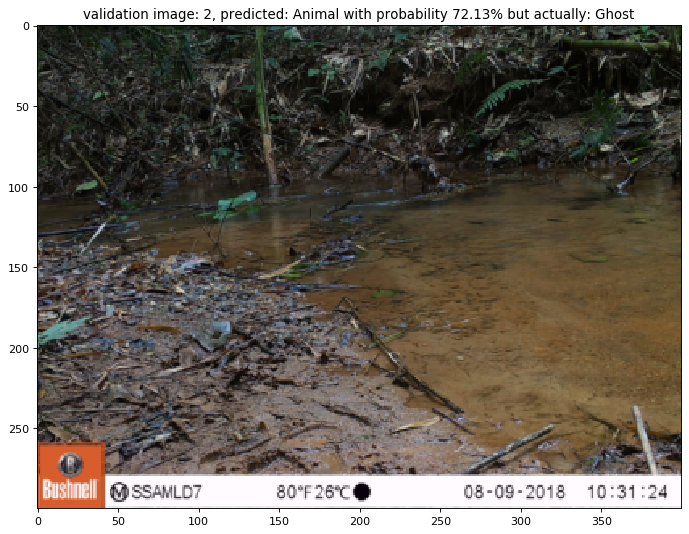

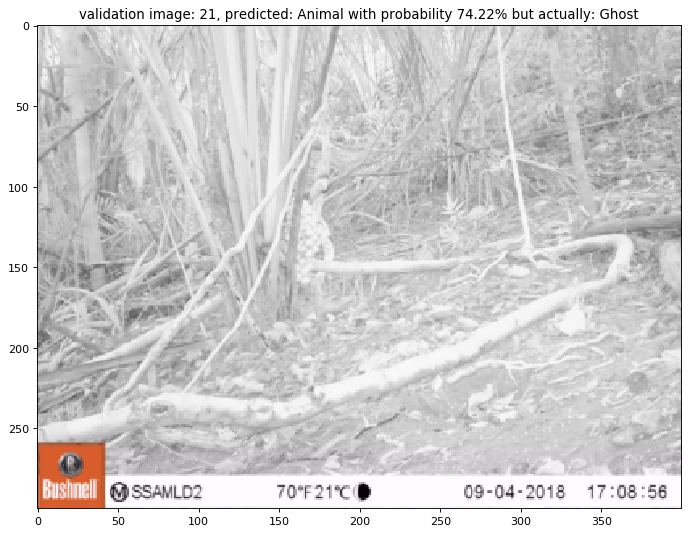

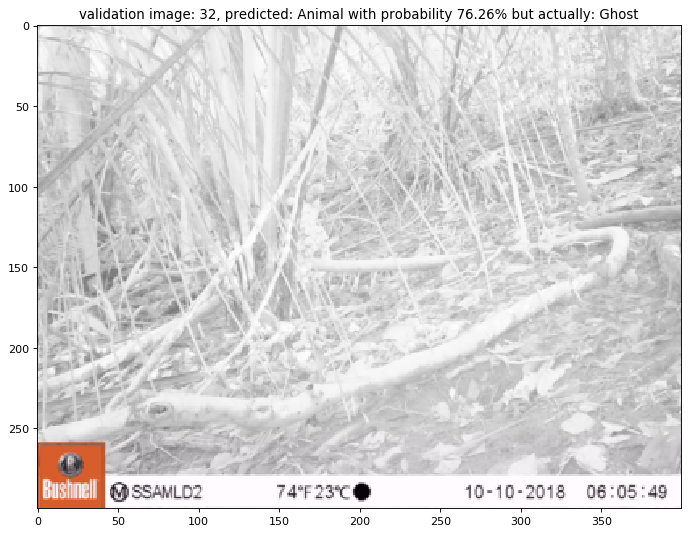

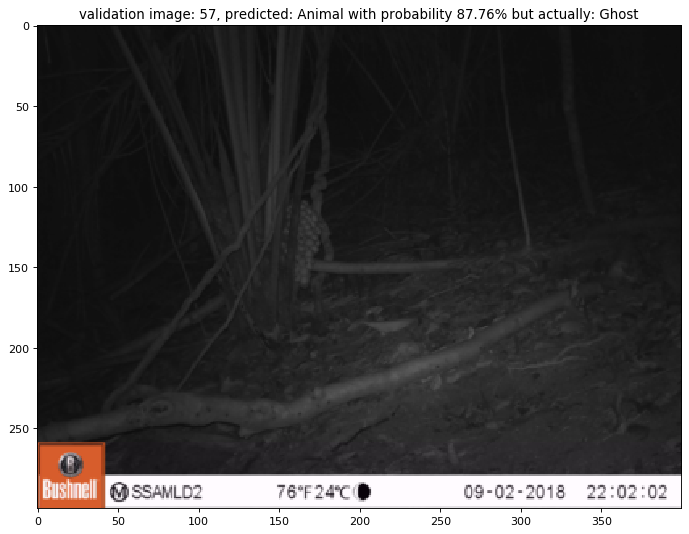

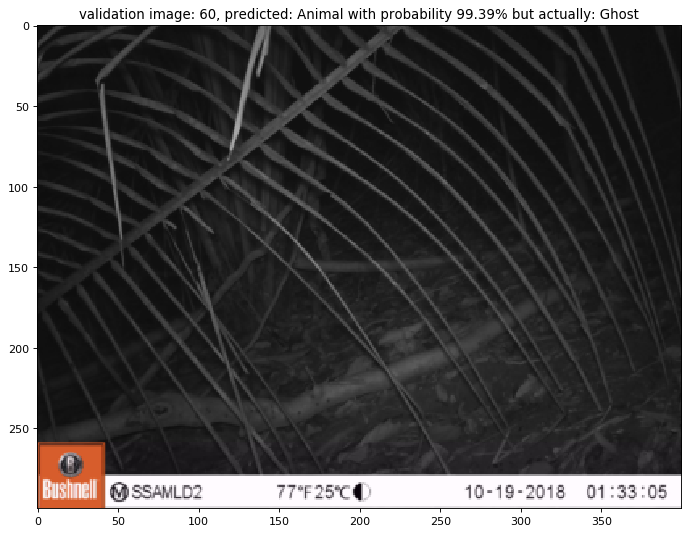

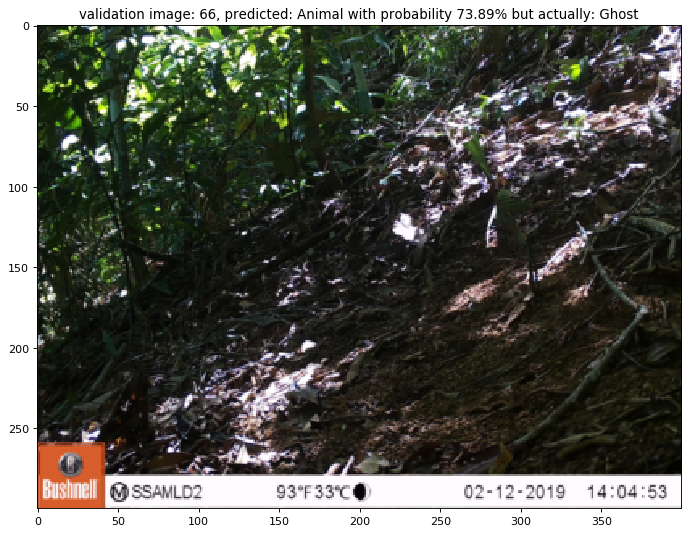

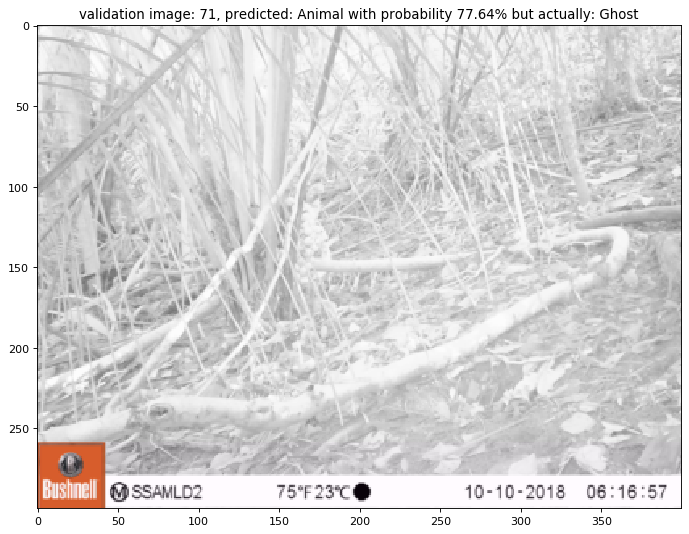

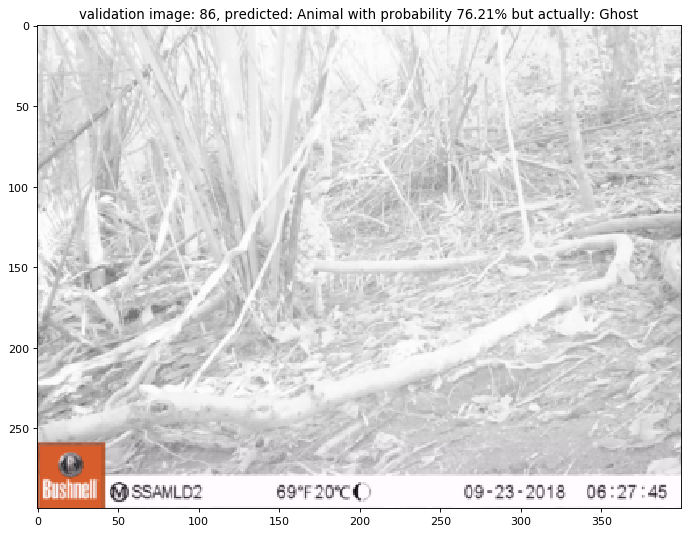

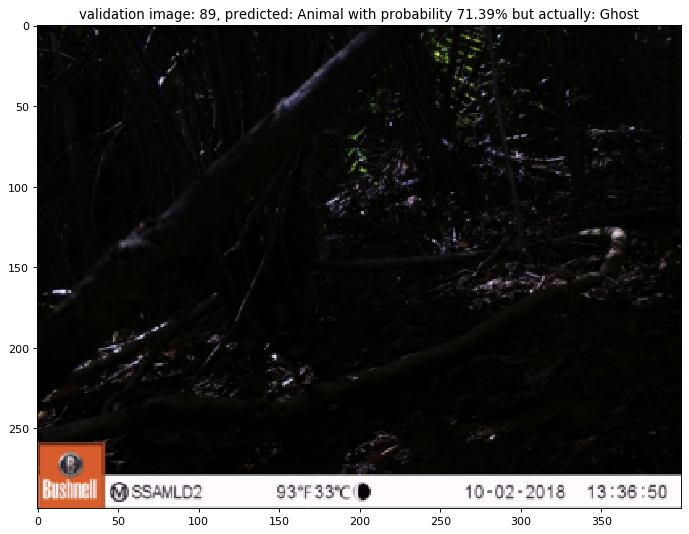

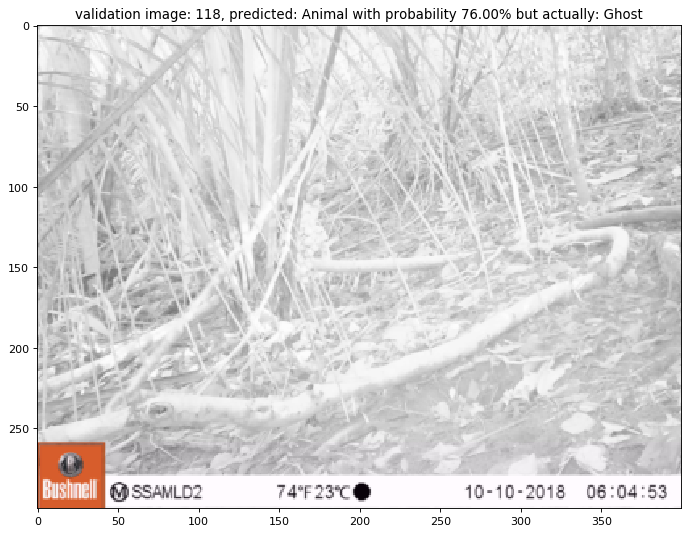

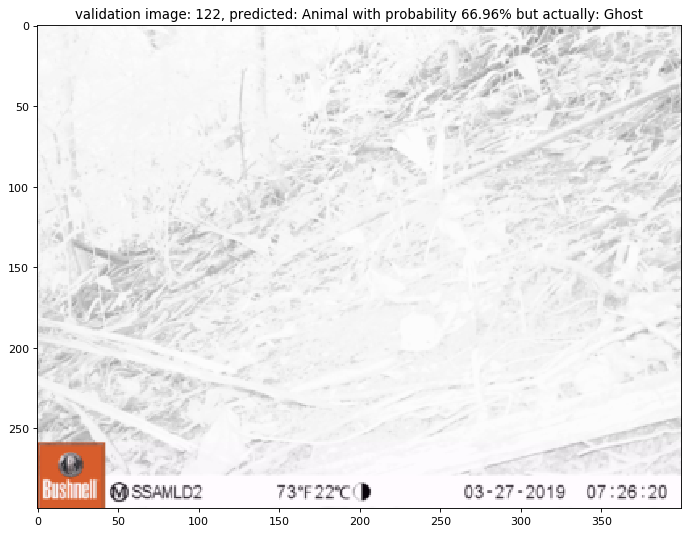

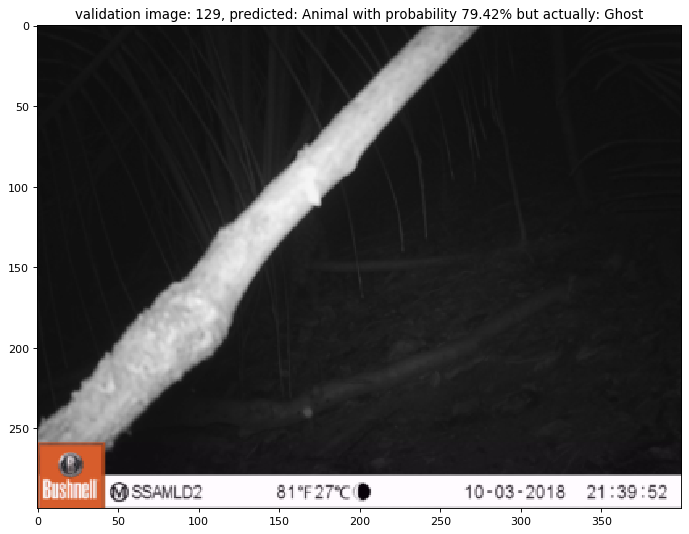

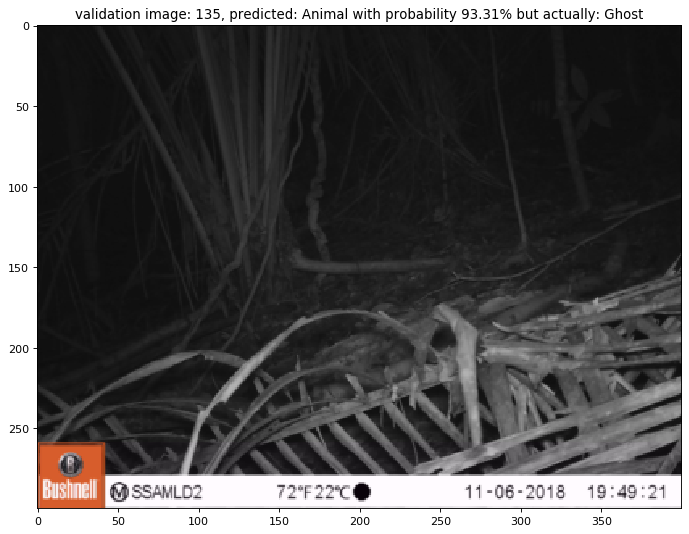

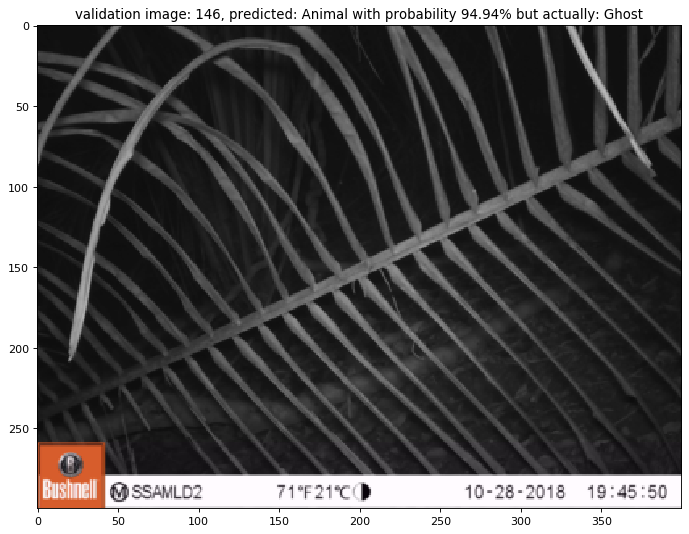

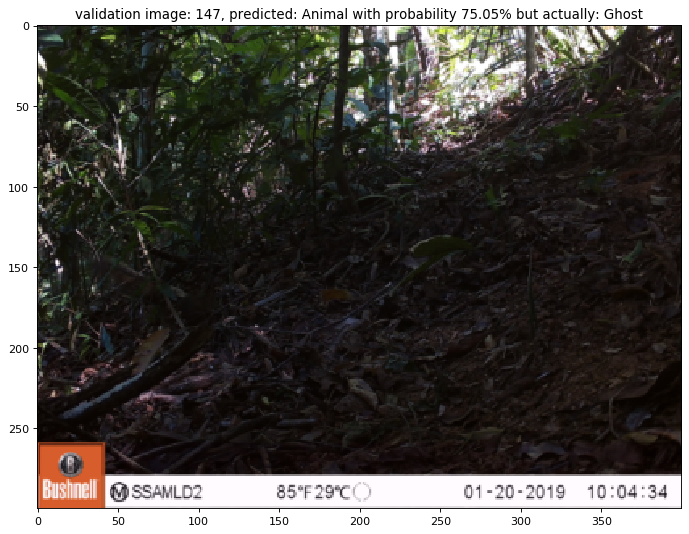

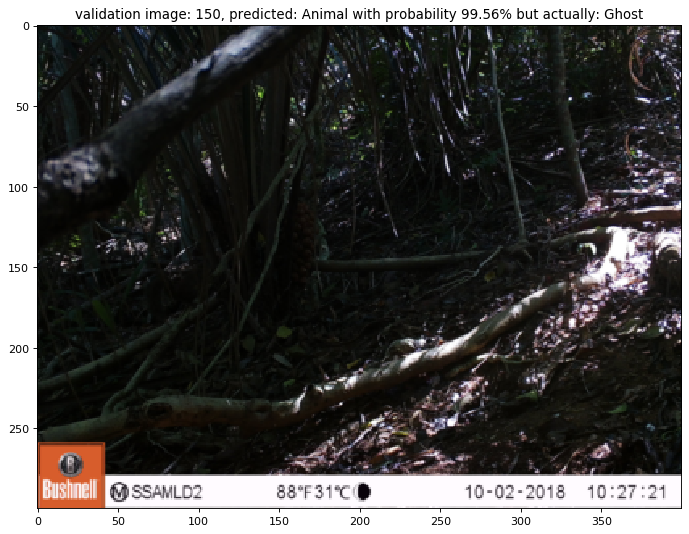

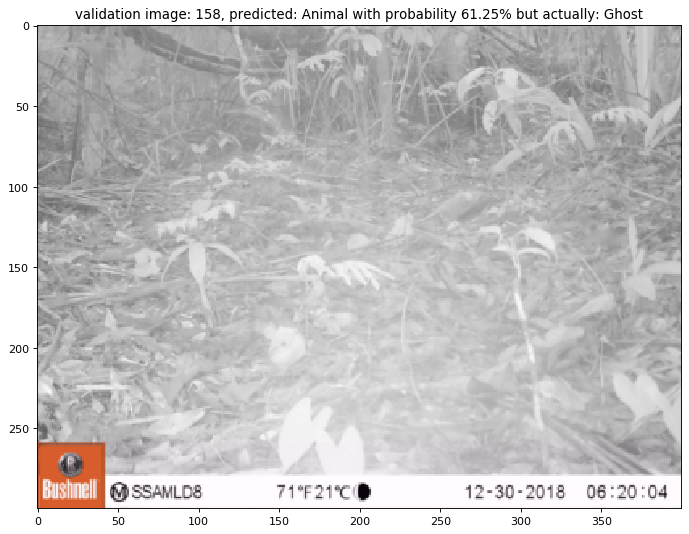

In [19]:
pred_list = []
actual_list = []
probablity_list = []
softmax = torch.nn.Softmax(dim=1)
misclassified_index = []

cam_trap = numpy.array(val_data.dataset.cam_trap)

with torch.no_grad():
    for image_index, (inputs, labels) in enumerate(val_data):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        actual_list += labels.tolist()

        outputs = model_ft(inputs)
        prob = softmax(outputs).tolist()
        probablity_list += prob
        
        _, preds = torch.max(outputs, 1)
        pred_list += preds.tolist()
        
        if any(preds != labels):
            misclassified_index += [image_index]
            util.imshow(inputs[preds != labels, :, :, :].cpu(), 
                        title=['validation image: {}, predicted: {} with probability {:.2f}% but actually: {}'.format(image_index, classes[int(preds[i])], max(prob[0])*100,classes[int(labels[i])]) 
                               for i in range(len(preds)) if labels[i] !=preds[i]],
                       savefig='savefig/validation_image_{}_camptrap_{}.png'.format(image_index, cam_trap[image_index]))